In [1]:
"""
Template for week 7 project in Data Visualization

Compute simple graph layouts using optimization and plot community structure
"""

import math
import random
import networkx as nx
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np 

import community

In [2]:
# Resource paths
PLOTS_PATH = "plots/"
DATA_PATH = "data/"



In [4]:
###############################################################################
# Provided code 

def make_graph(nodes, edges, name=None):
    """
    Input: list nodes, list edges consisting of tuples of integer node indices
    optional string name
    
    Output: networkx graph
    """
    
    grph = nx.Graph()
    grph.add_nodes_from(nodes)
    networkx_edges = [[nodes[edge[0]], nodes[edge[1]]] for edge in edges]
    grph.add_edges_from(networkx_edges)
    if name:
        grph.name = name
    
    return grph

In [5]:
NODE_RANGE = [-1, 1]

def random_node_pos():
    """
    Output: Tuple of random floats in NODE_RANGE
    """

    node_pos = (random.uniform(NODE_RANGE[0], NODE_RANGE[1]),
                random.uniform(NODE_RANGE[0], NODE_RANGE[1]))
    return node_pos

In [6]:
def random_layout(grph, seed=None):
    """
    Input: graph grph, float seed
    Output: dictionary indexed by nodes whose values are 2D node positions
    """
    if seed:
        random.seed(seed)
        
    layout = {}
    for node in grph.nodes():
        layout[node] = random_node_pos()
    
    return layout

In [7]:
def plot_graph(grph, layout, title, with_labels=True, node_colors='y', axs=None):
    """
    Input: graph grph, dictionary layout of 2D node positions, string title
    optional with_labels, node_colors as defined in draw_networkx
    optional axes axs
    
    Output: matplotlib figure with specified axes updated to
    include graph drawn using draw_networkx with node outlines being black
    """
    
    base_plot = axs is None
    if base_plot:
        fig, axs = plt.subplots()
    else:
        fig = axs.figure
    
    axs.set_title(title)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_aspect("equal")
    fig.tight_layout()
    
    nx.draw_networkx(grph, pos=layout, with_labels=with_labels, 
                     node_color=node_colors, cmap="terrain", ax=axs)
    axs.collections[0].set_edgecolor('k') 
    
    return fig

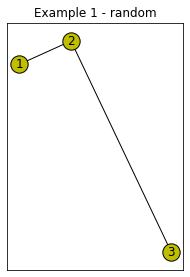

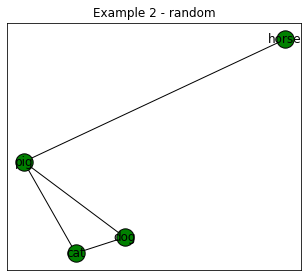

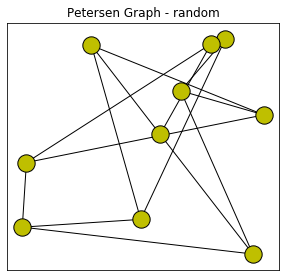

In [8]:
def test_plot_graph():
    """ Test graph plottiong code """
    
    nodes = [1, 2, 3]
    edges = [(0, 1), (1, 2)]
    example_1 = make_graph(nodes, edges, name="Example 1")
    layout = random_layout(example_1, seed=3)
    plot_graph(example_1, layout, example_1.name + " - random")
    
    nodes = ["cat", "dog", "pig", "horse"]
    edges = [(0, 1), (1, 2), (0, 2), (2, 3)]
    example_2 = make_graph(nodes, edges, name="Example 2")
    layout = random_layout(example_2, seed=4)
    plot_graph(example_2, layout, example_2.name + " - random", node_colors='g')
   
    petersen = nx.petersen_graph()
    layout = random_layout(petersen, seed=5)
    plot_graph(petersen, layout, petersen.name + " - random", with_labels=False)
    
test_plot_graph()    

In [9]:
###############################################################################
# Part 1 - Compute energy-based layout for graphs 

def get_node_indices(grph):
    """
    Input: graph grph
    
    Output: Dictionary whose keys are nodes in grph and whose values 
    are corresponding positions of nodes in grph.nodes()
    """
    node_dict = {}
    for index, node in enumerate(grph.nodes()):
        node_dict[node] = index
    
    return node_dict
    


In [10]:
def distance_error(flat_node_pos, path_lengths):
    """
    Input: 1D numpy array flat_node_pos of the form [x0 y0 x1 y1 ...],
    nested dictionary path_lengths of path lengths keyed by node indices
    
    Output: Sum of squares of differences between path lengths
    and geometric distances between pairs of nodes (based on values in flat_node_pos) 
    
    Note: path_lengths will be computed via all_pairs_shortest_path_length()
    """
    node_positions = flat_node_pos.reshape((-1, 2))
    num_nodes = node_positions.shape[0]

    error = 0.0

    for idx1 in range(num_nodes):
        for idx2 in range(num_nodes):
            if idx1 != idx2:  
                x_i, y_i = node_positions[idx1]
                x_j, y_j = node_positions[idx2]
                
                geometric_distance = np.sqrt((x_j - x_i)**2 + (y_j - y_i)**2)
                path_length = path_lengths[idx1][idx2]
                error += (path_length - geometric_distance) ** 2

    return error



In [11]:
def distance_layout(grph, seed=None):
    """
    Input: graph grph, optional integer seed
    
    Output: Dictionary of node positions keyed by nodes 
    and computed using shortest path distances
    
    Note: The initial guess for opt.minimize() should be generated via n calls 
    to random_node_pos() where n is the number of nodes in grph.
    """
    random.seed(seed)
   
    initial_guess = np.array([pos for node in grph.nodes() for pos in random_node_pos()])

    node_indices = {node: idx for idx, node in enumerate(grph.nodes())}
    path_lengths = dict(nx.all_pairs_shortest_path_length(grph))

    relabeled_path_lengths = {
        node_indices[start]: {node_indices[end]: length for end, length in ends.items()}
        for start, ends in path_lengths.items()
    }


    objective_function = lambda flat_node_pos: distance_error(flat_node_pos, relabeled_path_lengths)

    result = opt.minimize(objective_function, initial_guess, method='BFGS', options={'disp': True})

    optimized_positions = {
        node: (result.x[2 * index], result.x[2 * index + 1]) for node, index in node_indices.items()
    }

    return optimized_positions
    

In [12]:
#########################################################################
# Student code comparing layout methods (peer-graded)

def plot_spring_vs_distance(grph, with_labels=True, node_colors='y', seed=None):
    """
    Input: graph grph, optional bool with_labels, optional string node_colors, optional int seed
    
    Output: matplotlib figure consisting of side-by-side comparision of 
    grph using spring and distance layouts
    """
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    
    # Spring Layout
    spring_layout_graph = nx.spring_layout(grph, seed=seed)
    spring_title = "Spring Layout - " + grph.name  
    
    plot_graph(grph, spring_layout_graph, spring_title, 
               with_labels=with_labels, node_colors=node_colors, axs=ax1)
    
    # Distance Layout
    distance_layout_graph = distance_layout(grph, seed=seed)
    distance_title = "Distance Layout - " + grph.name
    
    plot_graph(grph, distance_layout_graph, distance_title, 
               with_labels=with_labels, node_colors=node_colors, axs=ax2)
    
    plt.tight_layout()
    return fig

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 224
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: 0.004475
         Iterations: 10
         Function evaluations: 150
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 24.819852
         Iterations: 28
         Function evaluations: 858
         Gradient evaluations: 39
         Current function value: 256.198910
         Iterations: 69
         Function evaluations: 3949
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: 28.034348
         Iterations: 53
         Function evaluations: 1984
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: 3.149800
         Iterations: 28
         Function evaluations: 770
         Gradient evaluation

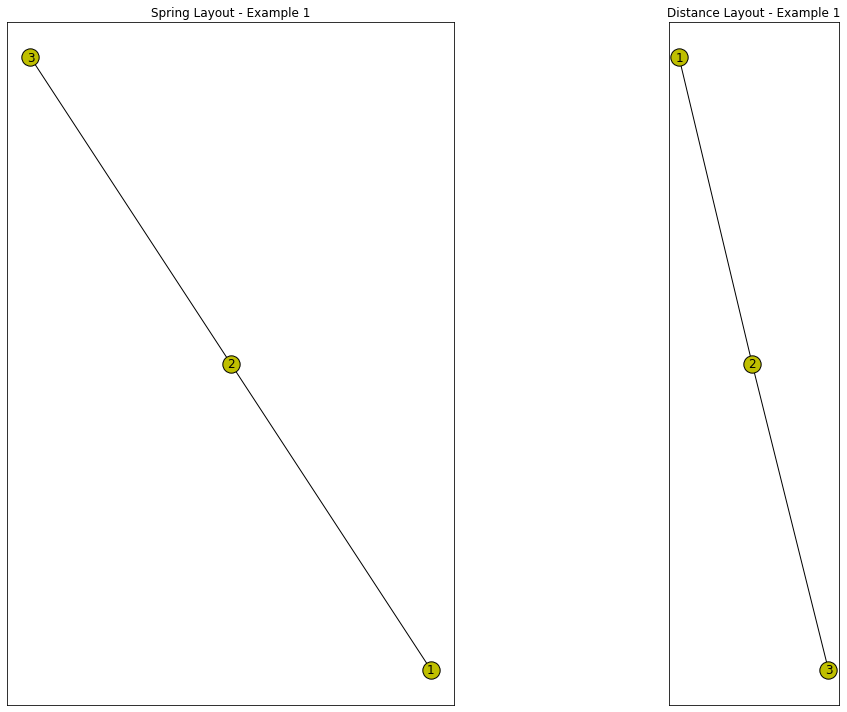

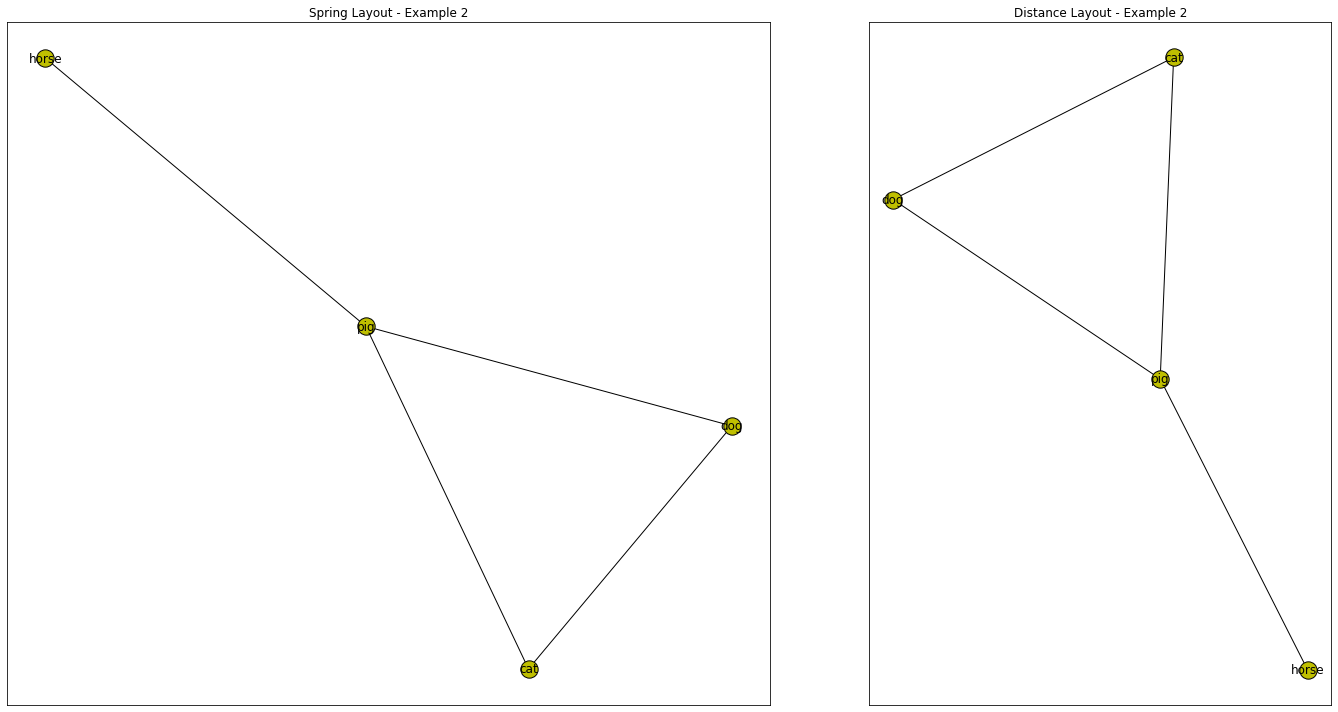

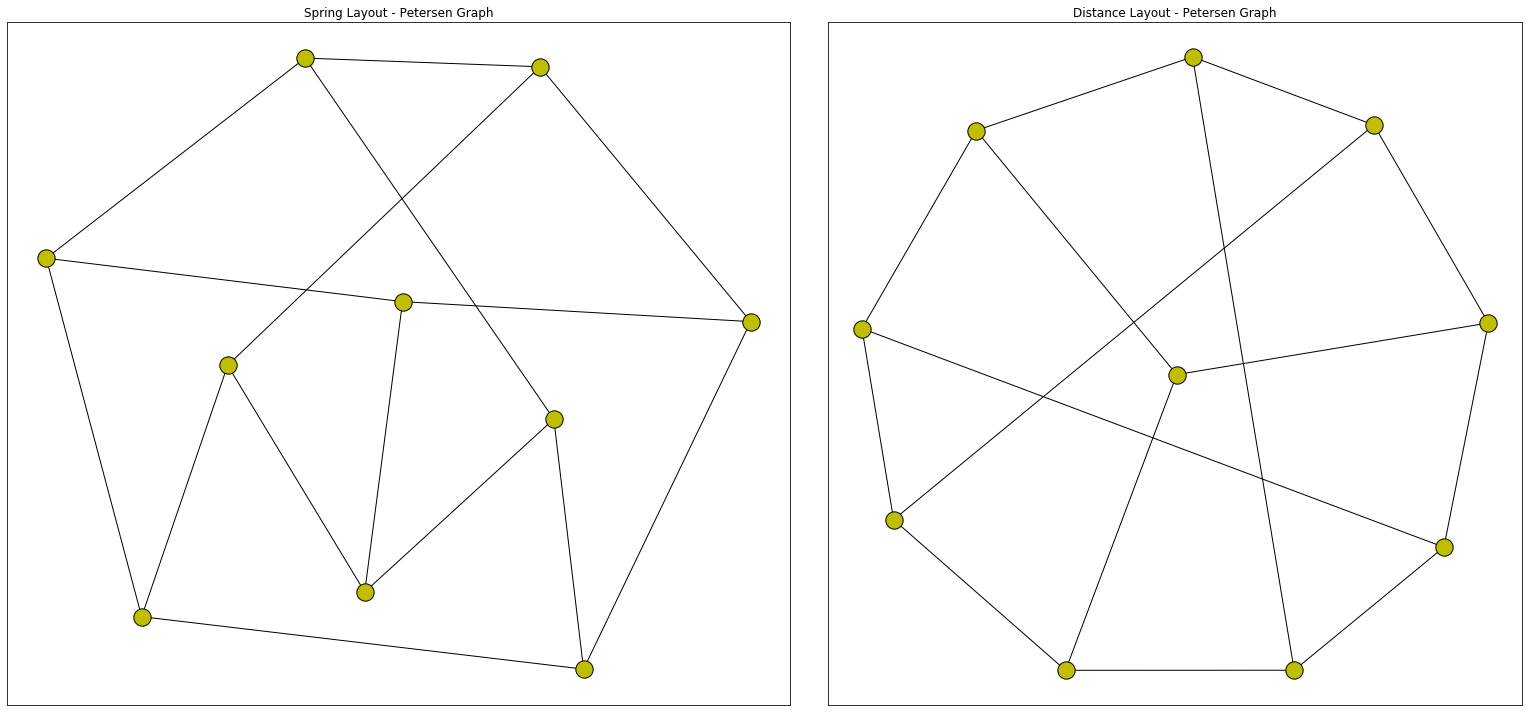

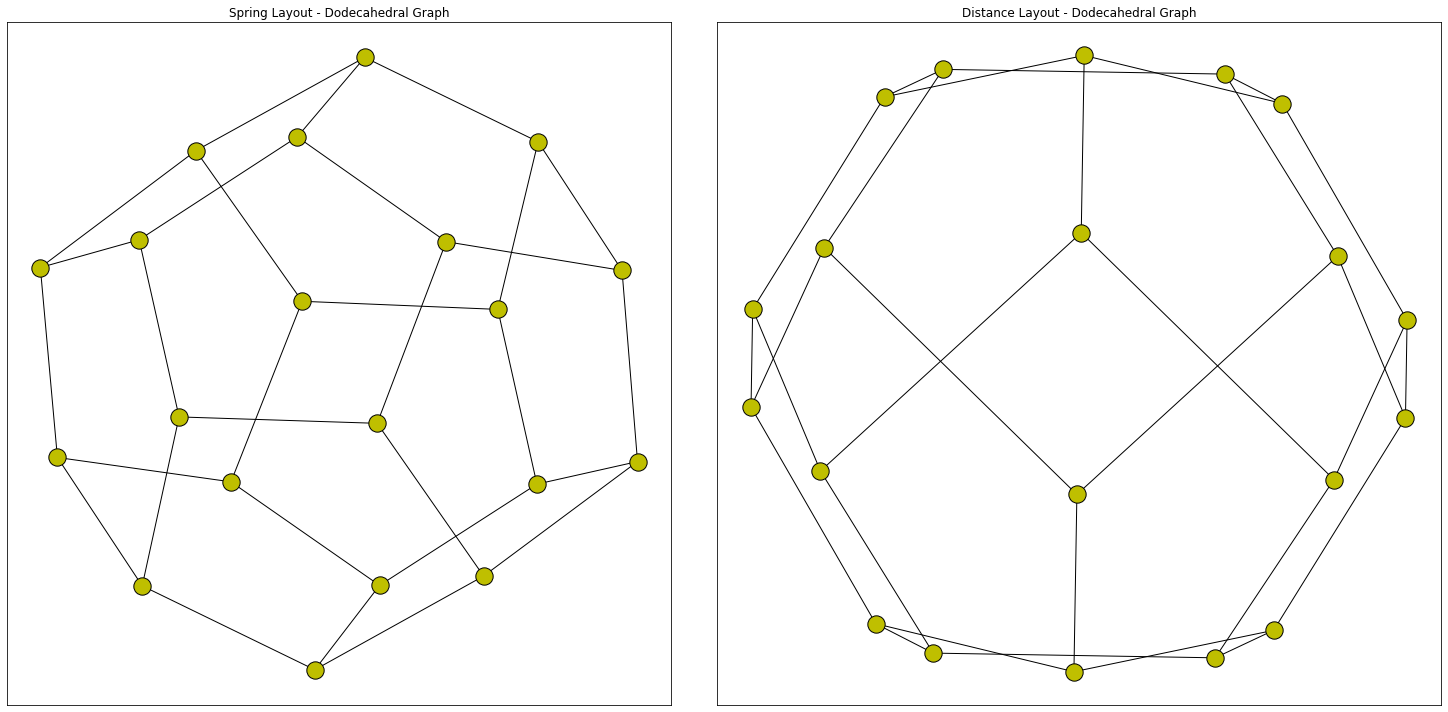

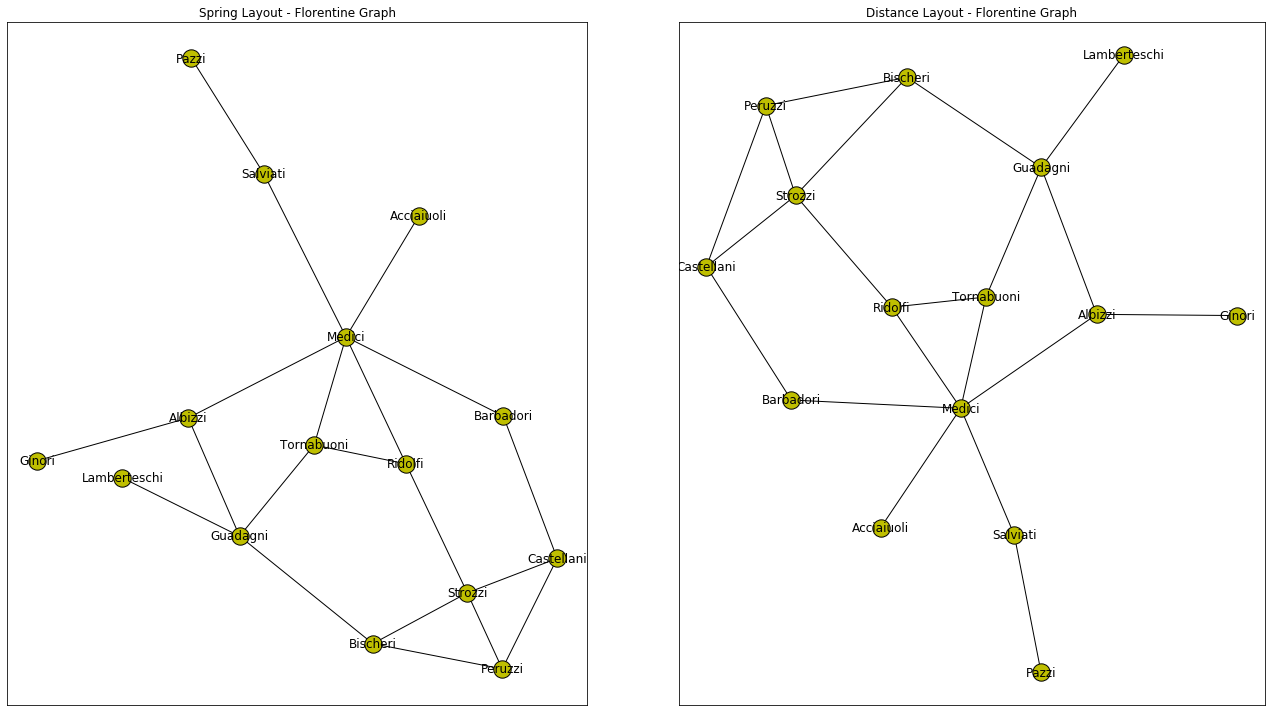

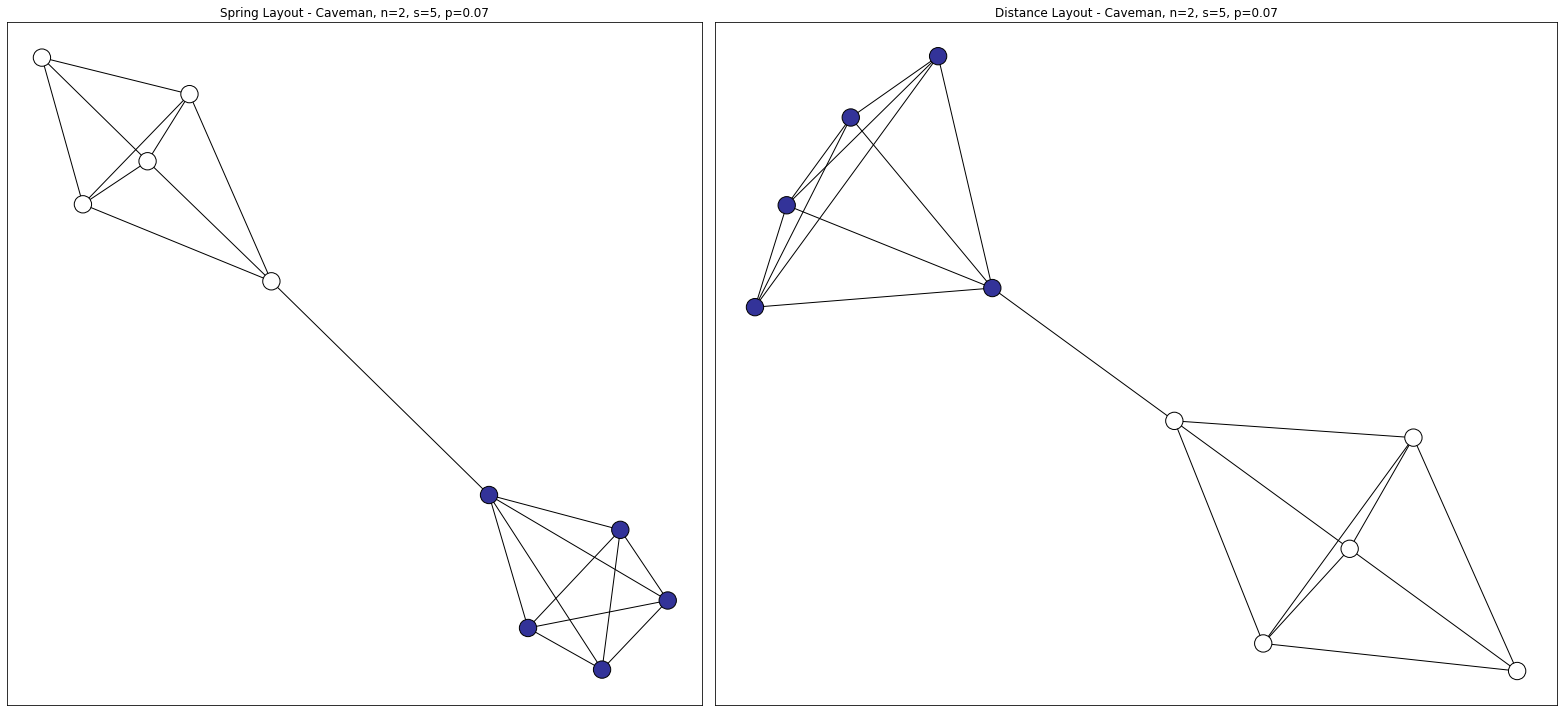

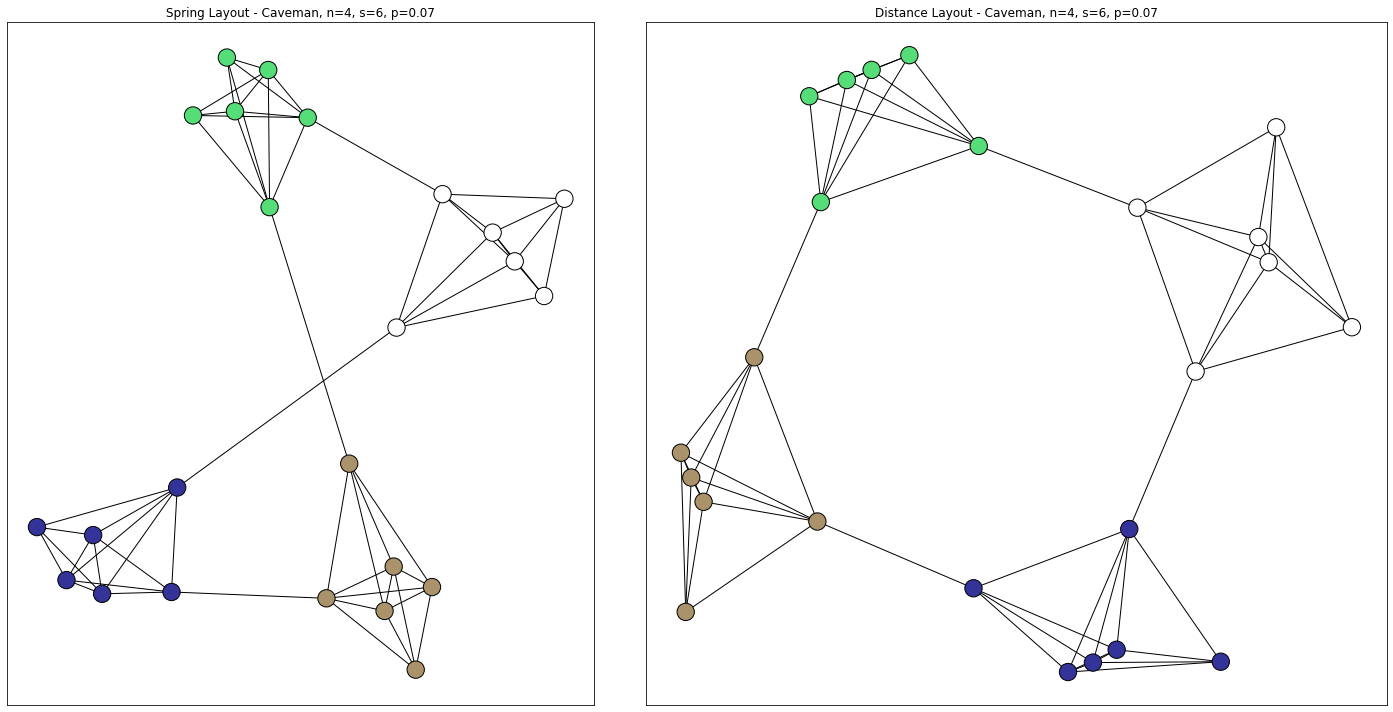

In [13]:
def test_plot_spring_vs_distance():
    """ Test plot_spring_vs_distance() """

    nodes = [1, 2, 3]
    edges = [(0, 1), (1, 2)]
    example_1 = make_graph(nodes, edges, name="Example 1")
    plot_spring_vs_distance(example_1, seed=2)

    nodes = ["cat", "dog", "pig", "horse"]
    edges = [(0, 1), (1, 2), (0, 2), (2, 3)]
    example_2 = make_graph(nodes, edges, name="Example 2")
    plot_spring_vs_distance(example_2, seed=2)
     
    petersen = nx.petersen_graph()
    plot_spring_vs_distance(petersen, False, seed=1)

    dodecahedral = nx.dodecahedral_graph()
    plot_spring_vs_distance(dodecahedral, False, seed=1)
    
    florentine = nx.florentine_families_graph()
    florentine.name = "Florentine Graph"
    plot_spring_vs_distance(florentine, seed=3)
    
    caveman_1 = nx.relaxed_caveman_graph(2, 5, 0.07, seed=3)
    caveman_1.name = "Caveman, n=2, s=5, p=0.07"
    cliques = [idx // 5 for idx in range(10)]
    plot_spring_vs_distance(caveman_1, False, cliques, seed=1)
    
    caveman_2 = nx.relaxed_caveman_graph(4, 6, 0.07, seed=5)
    caveman_2.name = "Caveman, n=4, s=6, p=0.07"
    cliques = [idx // 6 for idx in range(24)]
    plot_spring_vs_distance(caveman_2, False, cliques, seed=1)


test_plot_spring_vs_distance()

## Question 1 (optional)
**Based on these examples, what are the advantages/disadvantages of the two layout methods?**

Insert answer here.

In [14]:
##########################################################
# Part 2 - Compute and plot communities

def get_communities(grph, seed=None):
    """
    Input: graph grph, optional int seed
    
    Output: List of integers indicating the community for each
    corresponding node in grph
    """
    partition = community.best_partition(grph, random_state=seed) 
    community_labels = [partition[node] for node in grph.nodes()]
    
    return community_labels
    

In [15]:
def plot_caveman_communities(num_cliques, clique_size, prob, seed=None):
    """
    Input: integers num_cliques, clique_size, floats prob, seed
    
    Output: matplotlib figure containing plot of communities in
    relaxed caveman graphs using spring layout.
    """
    
    caveman_graph = nx.relaxed_caveman_graph(num_cliques, clique_size, prob, seed=seed)
    community_partitions = get_communities(caveman_graph, seed=seed)
    
    community_num = max(community_partitions) + 1
    
   
    cmap = plt.get_cmap('jet')
    node_colors = [cmap(i / community_num) for i in community_partitions]
    layout = nx.spring_layout(caveman_graph, seed=seed)
    
    plt.figure(figsize=(16, 9))
    nx.draw(caveman_graph, pos=layout, node_color=node_colors, with_labels=True,
            cmap=cmap, node_size=500, font_weight='bold', edge_color='gray')
    
    title = f"Relaxed Caveman Graph: {num_cliques} Cliques, Size {clique_size}, p={prob}"
    plt.title(title, size=20)
    
    plt.show()  


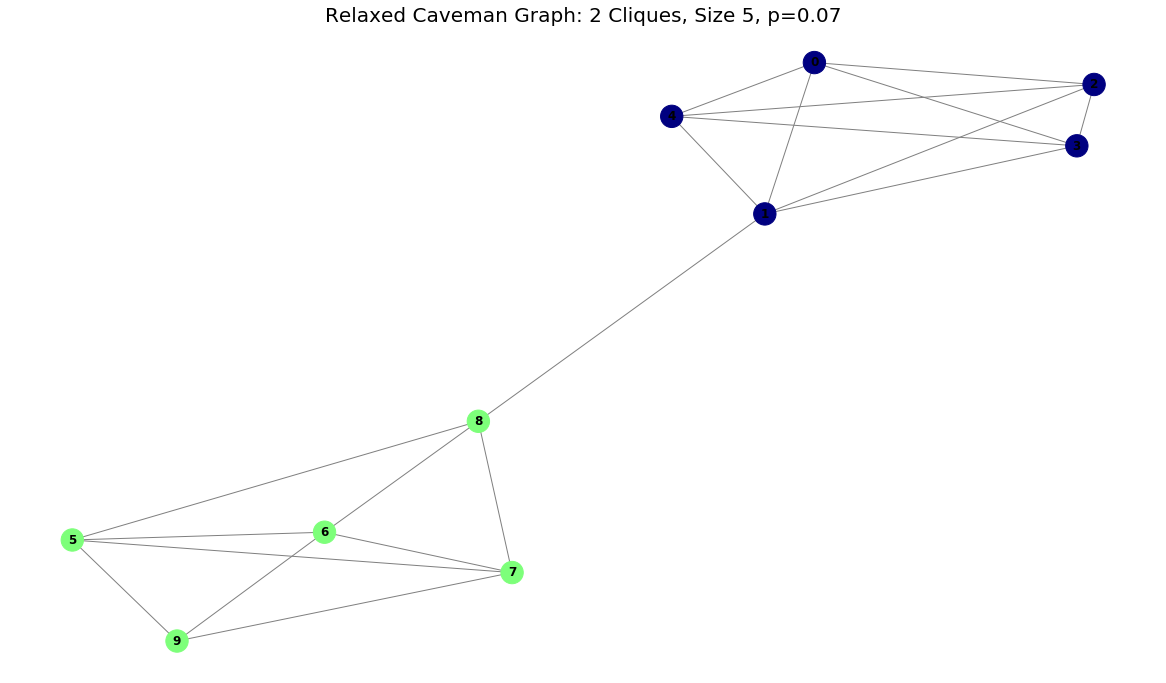

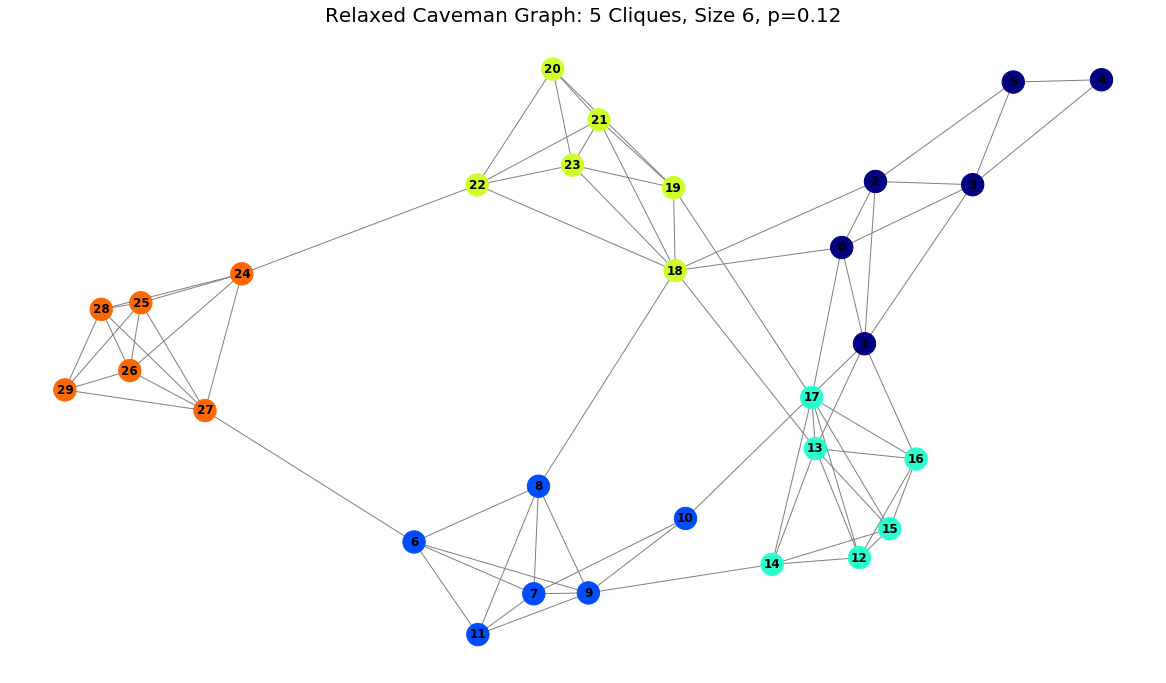

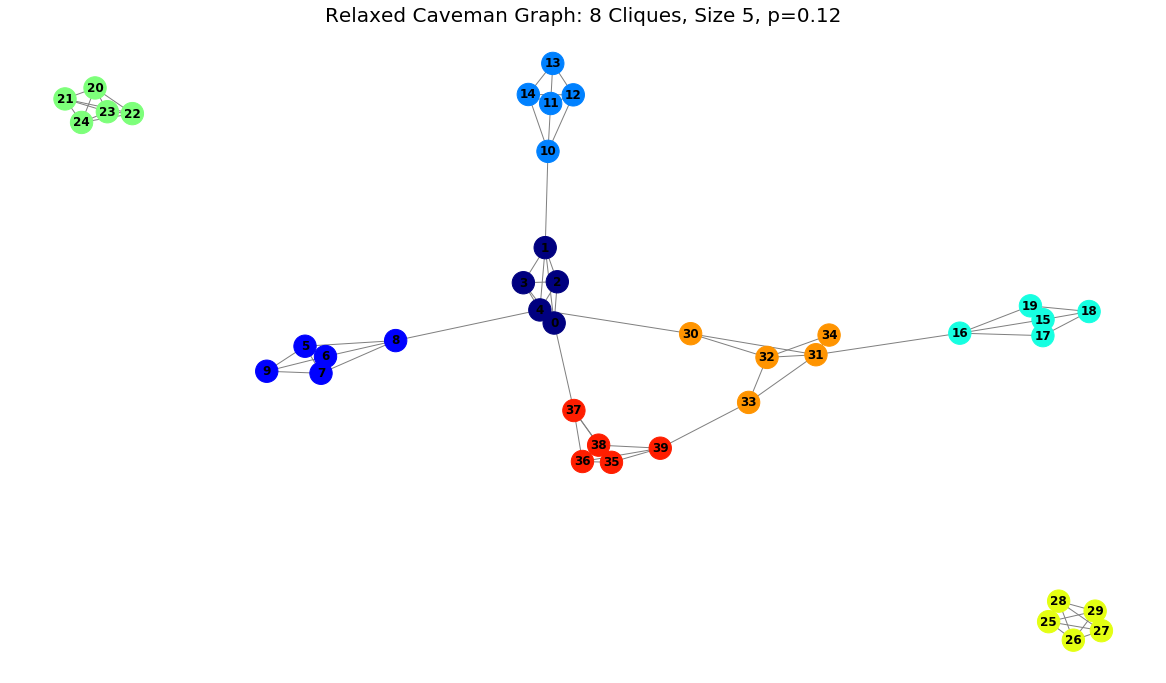

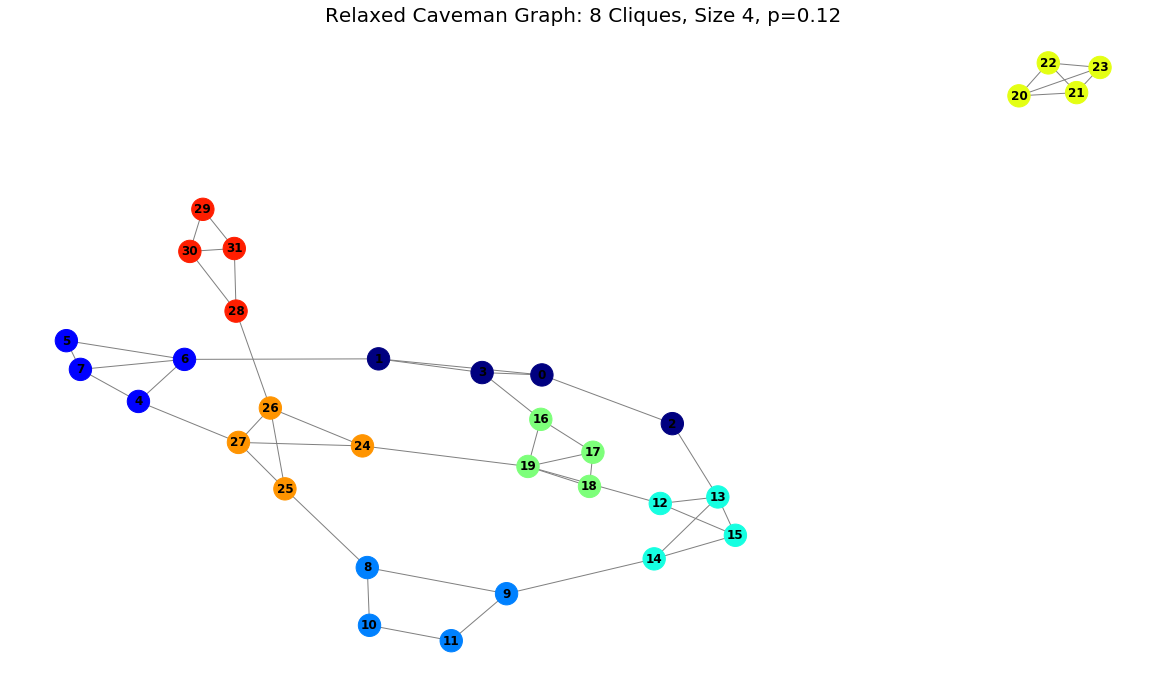

In [17]:
def test_plot_caveman_communities():
    """ Test plot_caveman_communities """
    
    plot_caveman_communities(2, 5, 0.07, seed=3)
    plot_caveman_communities(5, 6, 0.12, seed=7)
    
    # Note larger clique_size makes community detection more reliable
    plot_caveman_communities(8, 5, 0.12, seed=3)
    plot_caveman_communities(8, 4, 0.12, seed=7) 
        
test_plot_caveman_communities()

In [18]:
def plot_facebook_communities(seed=None):
    """
    Input: optional int seed
    
    Output: matplotlib figure consisting of communities for Facebook ego network from
    https://blog.dominodatalab.com/social-network-analysis-with-networkx/
    """
    
    facebook_graph = nx.read_edgelist("data/facebook_combined.txt", 
                                      create_using=nx.Graph(), nodetype=int)

    community_partitions = get_communities(facebook_graph, seed=seed)

    community_num = max(community_partitions) + 1
    node_colors = [plt.get_cmap('tab20c')(i / community_num) for i in community_partitions]

    layout = nx.spring_layout(facebook_graph, seed=seed)

    fig, axs = plt.subplots(figsize=(10, 8))  
    nx.draw_networkx(facebook_graph, pos=layout, with_labels=False,
                     node_color=node_colors, cmap=plt.get_cmap('tab20c'), 
                     node_size=35, ax=axs)
    

    axs.set_title("Spring Layout - Facebook Ego Network Communities Graph")

    return fig


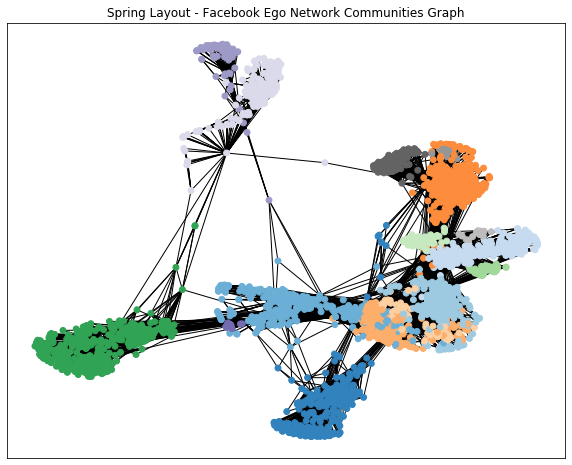

In [19]:
def test_plot_facebook_communities():
    """ Call plot_face_communities() """
    
    plot_facebook_communities(seed=3)
    
test_plot_facebook_communities()

## Question 2 (optional)
**Based on these examples, how well does the get_community() method detect communities in a graph?**

Insert answer here.